In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [4]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [5]:
def split(n,df):
    ones = np.zeros(len(df),dtype=np.bool)
    ones[:n] = 1
    ones = np.random.permutation(ones)
    return df[ones].copy(), df[~ones].copy()

In [6]:
def splitRawData(df):
    df_trn, y_trn, nas = proc_df(df, 'Survived')
    X_train, X_valid = split(711,df_trn)
    y_train, y_valid = split(711,y_trn)

In [7]:
PATH = "data/titanic/"
np.random.seed(41)

In [8]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False)
len(df_raw)

891

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
display_all(df_raw.tail(10).T)

,881,882,883,884,885,886,887,888,889,890
PassengerId,882,883,884,885,886,887,888,889,890,891
Survived,0,0,0,0,0,0,1,0,1,0
Pclass,3,3,2,3,3,2,1,3,1,3
Name,"Markun, Mr. Johann","Dahlberg, Miss. Gerda Ulrika","Banfield, Mr. Frederick James","Sutehall, Mr. Henry Jr","Rice, Mrs. William (Margaret Norton)","Montvila, Rev. Juozas","Graham, Miss. Margaret Edith","Johnston, Miss. Catherine Helen ""Carrie""","Behr, Mr. Karl Howell","Dooley, Mr. Patrick"
Sex,male,female,male,male,female,male,female,female,male,male
Age,33,22,28,25,39,27,19,NaN,26,32
SibSp,0,0,0,0,0,0,0,1,0,0
Parch,0,0,0,0,5,0,0,2,0,0
Ticket,349257,7552,C.A./SOTON 34068,SOTON/OQ 392076,382652,211536,112053,W./C. 6607,111369,370376
Fare,7.8958,10.5167,10.5,7.05,29.125,13,30,23.45,30,7.75


In [11]:
df_raw[df_raw.Name.str.contains('Johnston')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
783,784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.45,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S


In [12]:
df_raw[df_raw.Name.str.contains('Palsson')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,NaN,S
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.075,NaN,S
374,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S


In [13]:
df_raw[df_raw.Name.str.contains('Andersson')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S


In [14]:
df_trn, y_trn, nas = proc_df(df_raw, 'Survived')

In [15]:
display_all(df_trn.tail(10).T)

,881,882,883,884,885,886,887,888,889,890
PassengerId,882,883,884,885,886,887,888,889,890,891
Pclass,3,3,2,3,3,2,1,3,1,3
Name,511,194,62,794,685,549,304,414,82,221
Sex,2,1,2,2,1,2,1,1,2,2
Age,33,22,28,25,39,27,19,28,26,32
SibSp,0,0,0,0,0,0,0,1,0,0
Parch,0,0,0,0,5,0,0,2,0,0
Ticket,395,509,566,651,481,102,15,676,9,467
Fare,7.8958,10.5167,10.5,7.05,29.125,13,30,23.45,30,7.75
Cabin,0,0,0,0,0,0,31,0,61,0


# Naive Training with Raw Data

In [16]:
X_train, X_valid = split(711,df_trn)
y_train, y_valid = split(711,y_trn)
y_train.sum()/len(y_train),y_valid.sum()/len(y_valid)

(0.379746835443038, 0.4)

In [17]:
len(X_train),len(X_valid)

(711, 180)

In [18]:
X_train.Age.mean(),X_valid.Age.mean()

(29.509493670886076, 28.777333333333335)

In [19]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=150, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6497862896539309, 1.0, 0.5777777777777777, 0.5625879043600562]


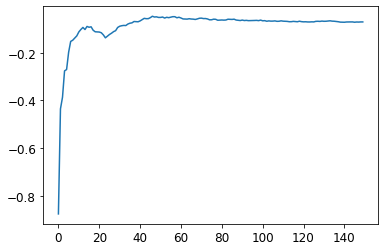

In [20]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(len(m.estimators_))]);

In [21]:
pv = [metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(len(m.estimators_))]
np.argmax(pv),np.max(pv)

(46, -0.04721006656271487)

In [22]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=29, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6497862896539309, 1.0, 0.5777777777777777, 0.549929676511955]


In [23]:
metrics.r2_score(y_valid,np.zeros(len(y_valid))),metrics.r2_score(y_valid,np.ones(len(y_valid))),metrics.r2_score(y_valid,y_valid)

(-0.6666666666666665, -1.5, 1.0)

In [24]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=64, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6454972243679028, 1.0, 0.5833333333333334, 0.5541490857946554]


# Extracting Salutation

In [25]:
re.search('[^,]*, ([^\.]*)\.','Butt, Major. Archibald Willingham').group(1)

'Major'

In [26]:
df_raw.Name.str.extract('[^,]*, ([^\.]*)\.').groupby(0).first()

""
0
Capt
Col
Don
Dr
Jonkheer
Lady
Major
Master
Miss


In [27]:
df_raw['Salutation']=df_raw.Name.str.extract('[^,]*, ([^\.]*)\.')

In [28]:
df_raw[['Salutation','Name']]

,Salutation,Name
0,Mr,"Braund, Mr. Owen Harris"
1,Mrs,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,"Heikkinen, Miss. Laina"
3,Mrs,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,"Allen, Mr. William Henry"
...,...,...
886,Rev,"Montvila, Rev. Juozas"
887,Miss,"Graham, Miss. Margaret Edith"
888,Miss,"Johnston, Miss. Catherine Helen ""Carrie"""
889,Mr,"Behr, Mr. Karl Howell"


# Pclass average

In [29]:
surByClass = df_raw[['Pclass','Survived']].groupby('Pclass').mean()
surByClass.rename(columns={'Survived':'SurvivedByClass'},inplace=True)
surByClass

,SurvivedByClass
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [30]:
df_raw_plus_surByClas = df_raw.merge(surByClass,left_on='Pclass',right_on='Pclass')
df_raw_plus_surByClas[['SurvivedByClass']].tail(3)

,SurvivedByClass
888,0.472826
889,0.472826
890,0.472826


In [31]:
df_raw_plus_surByClas.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,SurvivedByClass
888,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0,NaN,S,Mrs,0.472826
889,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5,NaN,S,Mr,0.472826
890,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0,NaN,S,Rev,0.472826


In [32]:
splitRawData(df_raw)

In [33]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=73, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6624868971450597, 1.0, 0.5611111111111111, 0.5625879043600562]


In [34]:
splitRawData(df_raw_plus_surByClas)

In [35]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=73, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6497862896539309, 1.0, 0.5777777777777777, 0.5527426160337553]


# Age Avg

In [36]:
surByAge = df_raw[['Age','Survived']].groupby('Age').mean()
surByAge.rename(columns={'Survived':'SurvivedByAge'},inplace=True)
surByAge.tail(3)

,SurvivedByAge
Age,
71.0,0.0
74.0,0.0
80.0,1.0


In [37]:
df_raw_plus_surByAge = df_raw.merge(surByAge,left_on='Age',right_on='Age')
df_raw_plus_surByAge[['Name','Age','SurvivedByAge']].tail(3)

,Name,Age,SurvivedByAge
711,"Thomas, Master. Assad Alexander",0.42,1.0
712,"Lemberopolous, Mr. Peter L",34.50,0.0
713,"Svensson, Mr. Johan",74.00,0.0


In [38]:
splitRawData(df_raw)

In [39]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=73, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6708203932499369, 1.0, 0.55, 0.5836849507735584]


In [40]:
splitRawData(df_raw_plus_surByAge)

In [41]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=73, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.0, 0.6411794687223782, 1.0, 0.5888888888888889, 0.5583684950773559]


# Has Relatives

In [42]:
#ToDo: child +  mather relationship?

# Feature Importance

In [43]:
fi = rf_feat_importance(m, X_train)
fi = fi.sort_values(by='imp')
fi

,cols,imp
11,Age_na,0.017356
1,Pclass,0.021929
6,Parch,0.025631
3,Sex,0.026620
10,Embarked,0.029959
5,SibSp,0.032824
9,Cabin,0.045114
4,Age,0.131058
8,Fare,0.131680
7,Ticket,0.171644


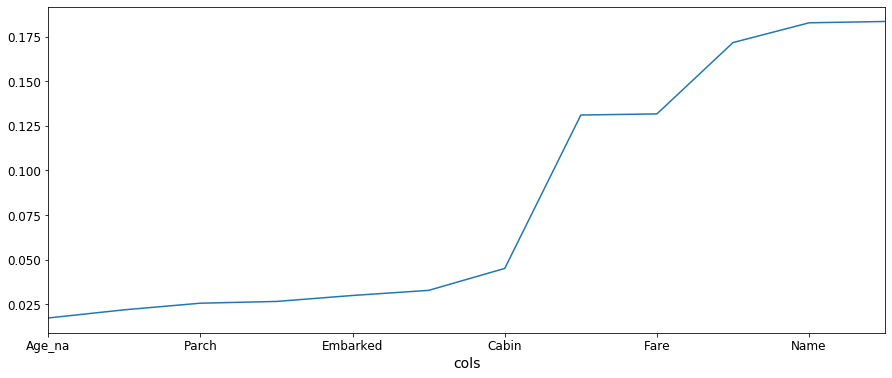

In [44]:
fi.plot('cols', 'imp', figsize=(15,6), legend=False);

# Parameters

In [45]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=50, min_samples_leaf=3, max_features=0.5,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.13521873720643093, 0.6790516262487788, 0.9817158931082982, 0.5388888888888889, 0.5386779184247539]


In [46]:
for minS in range(5):
    for max_f in range(5):
        print('Min Samples:',str(minS+1),'  Max Features:',str((max_f+1)/10))
        m = RandomForestClassifier(n_jobs=-1,n_estimators=50, min_samples_leaf=minS+1, max_features=(max_f+1)/10,oob_score=True)
        m.fit(X_train,y_train)
        print_score(m)

Min Samples: 1   Max Features: 0.1
[0.0, 0.6540472290116194, 1.0, 0.5722222222222222, 0.5485232067510548]
Min Samples: 1   Max Features: 0.2
[0.0, 0.6497862896539309, 1.0, 0.5777777777777777, 0.5485232067510548]
Min Samples: 1   Max Features: 0.3
[0.0, 0.6540472290116194, 1.0, 0.5722222222222222, 0.5583684950773559]
Min Samples: 1   Max Features: 0.4
[0.0, 0.6749485577105528, 1.0, 0.5444444444444444, 0.5611814345991561]
Min Samples: 1   Max Features: 0.5
[0.0, 0.6749485577105528, 1.0, 0.5444444444444444, 0.5611814345991561]
Min Samples: 2   Max Features: 0.1
[0.2515773027133138, 0.6871842709362768, 0.9367088607594937, 0.5277777777777778, 0.5780590717299579]
Min Samples: 2   Max Features: 0.2
[0.16771820180887587, 0.6582805886043833, 0.9718706047819972, 0.5666666666666667, 0.5668073136427567]
Min Samples: 2   Max Features: 0.3
[0.1125087900926024, 0.695221787153807, 0.9873417721518988, 0.5166666666666667, 0.5611814345991561]
Min Samples: 2   Max Features: 0.4
[0.1452482234435317, 0.6666

In [47]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=19, min_samples_leaf=2, max_features=0.3,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.21543793099105052, 0.6411794687223782, 0.9535864978902954, 0.5888888888888889, 0.5344585091420534]


# Drop Cols

In [48]:
X_train = X_train.drop(['Parch','Age_na'], axis=1)
X_valid = X_valid.drop(['Parch','Age_na'], axis=1)

In [49]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=50, min_samples_leaf=2, max_features=0.3,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.07500586006173493, 0.6912147117775908, 0.9943741209563994, 0.5222222222222223, 0.5611814345991561]


In [50]:
fi = rf_feat_importance(m, X_train)
fi = fi.sort_values(by='imp')
fi

,cols,imp
1,Pclass,0.016255
9,Embarked,0.023117
3,Sex,0.026492
5,SibSp,0.029354
8,Cabin,0.044373
7,Fare,0.139208
4,Age,0.143063
6,Ticket,0.182217
2,Name,0.188782
0,PassengerId,0.207138


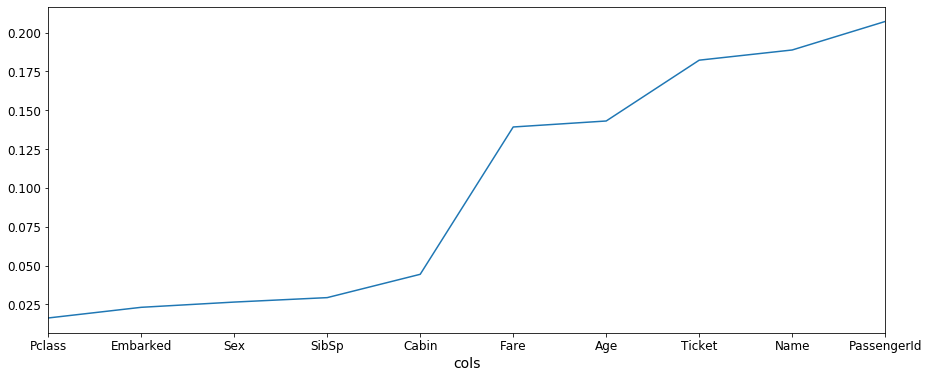

In [51]:
fi.plot('cols', 'imp', figsize=(15,6), legend=False);

In [52]:
X_train = X_train.drop(['Sex'], axis=1)
X_valid = X_valid.drop(['Sex'], axis=1)

In [53]:
m = RandomForestClassifier(n_jobs=-1,n_estimators=50, min_samples_leaf=2, max_features=0.3,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.1452482234435317, 0.699205898780101, 0.9789029535864979, 0.5111111111111111, 0.5583684950773559]


# Confidence

In [55]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
x = X_valid.copy()
x['Survived'] = y_valid
x['Pred'] = np.mean(preds,axis=0)
x['Pred_std'] = np.std(preds,axis=0)

In [69]:
xx = x[['Survived','Pred','Pred_std']]
gg = xx.groupby('Survived',as_index=False).mean()
gg

,Survived,Pred,Pred_std
0,0,0.332778,0.444989
1,1,0.324167,0.449682


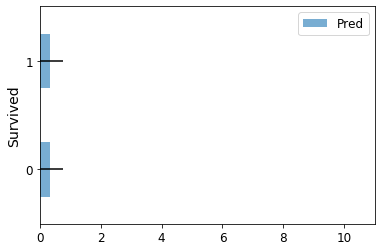

In [70]:
gg.plot(x='Survived', y='Pred', kind='barh', xerr='Pred_std', alpha=0.6, xlim=(0,11));

In [92]:
data = pd.DataFrame(data=preds.T)

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'